In [4]:
import pandas as pd
from pathlib import Path
from utils.distfit import *
from utils.scenario_gen import *
from utils.clustering import *
from scipy.spatial.distance import pdist, cdist
import numpy as np
import scipy as sp
import copy
import itertools
from joblib import Parallel, delayed

In [5]:
datapath = Path(Path().cwd().parents[3]) / 'EGU23' / 'data'
savepath = datapath / 'Forecasts' / 'Scenarios'
distpath = datapath / 'Forecasts' / 'Distributions'
tpepath = datapath / 'Forecasts' / 'TPE Search results'

waterboards = ['HHNK', 'HDSR', 'Rijnland', 'Waternet']


In [6]:
def get_tpepath(name):
    if name in ['Waternet', 'HDSR', 'HHNK']:
        return tpepath / 'CQRDNN_10_280223_ClusteredUniform' / name / 'Forecasts'
    elif name == 'Rijnland':
        return tpepath / 'CQRDNN_10_270323_NotClustered' / name / 'Forecasts'
    elif name == 'WL':
        return tpepath / 'CQRDNN_WL_IJmuiden' / 'Forecasts'
    elif name == 'DAM':
        return tpepath / 'CQRDNN_DAM' / 'Forecasts'
    else:
        raise ValueError(f'Invalid name: {name}')
    
def get_distpath(name):
    if name in waterboards:
        return distpath / f'{name}.csv'
    elif name == 'WL':
        return distpath / f'WL.csv'
    elif name == 'DAM':
        return distpath / f'DAM_hourcols.csv'
    else:
        raise ValueError(f'Invalid name: {name}')
    
def get_data(name):
    path = get_tpepath(name)
    if name == 'DAM':
        val_data = pd.concat([pd.read_pickle(path / 'y_train.pkl'), pd.read_pickle(path / 'y_val.pkl')], axis=0).astype(float).sort_index()
        val_data = val_data.loc[:, [col for col in val_data.columns if ('q0.5' in col) and ('NL' in col)]]
        val_data.columns = [f'DAM NL +{h}' for h in range(1,49)]
        distribution_df_ = pd.read_csv(get_distpath(name), index_col=[0,1], parse_dates=True, header=[0,1])
        distribution_df_.index = distribution_df_.index.droplevel(1)
        indices = np.array([i for i in range(0, len(distribution_df_.index), 2)])
        distribution_df = pd.concat([distribution_df_.iloc[indices, :], distribution_df_.iloc[indices+1, :]], axis=1)
        distribution_df.columns = pd.MultiIndex.from_product([[f'DAM NL_{i}' for i in range(1,49)], ['dist', 'params', 'KS']])
    
    else:
        if name in ['Rijnland', 'WL']:
            f = 'y_train.csv'
        else:
            f = 'y_trainval.csv'
        val_data = pd.read_csv(path / f, index_col=0, parse_dates=True).astype(float)
        if name in waterboards:
            val_data = val_data.loc[:, [f'Aggregated +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'Q +{i}' for i in range(1, 49)]
            
        elif name == 'WL':
            val_data = val_data.loc[:, [f'WL +{i} q0.5' for i in range(1, 49)]]
            val_data.columns =  [f'WL +{i}' for i in range(1, 49)]
        distribution_df = pd.read_csv(get_distpath(name), index_col=0, parse_dates=True, header=[0,1])
    return val_data, distribution_df

In [16]:
name = 'WL'
val_data, distribution_df = get_data(name)

In [29]:
valmin = np.floor(val_data.min().min() * 10) / 10 / 10
valmax = np.ceil(val_data.max().max() * 10) / 10 * 10
n_scenarios = 100
idx = 100

if name in waterboards:
    varname = 'Aggregated'
    distributionloader = DistributionLoader(distribution_df, 'Aggregated', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='Aggregated', n=48, threshold=None)
    bn.make_structure()
    scenarios = bn(idx, n_scenarios).round(2)
    
    # Mask all negative values to zero
    scenarios[scenarios < 0] = 0

elif name == 'WL':
    varname = 'WL'
    distributionloader = DistributionLoader(distribution_df, 'WL', valmin=-5, valmax=5)
    bn = BN(val_data, distributionloader, varname='WL', n=48, threshold=None)
    bn.make_structure()
    scenarios = bn(idx, n_scenarios).round(2)

elif name == 'DAM':
    varname = 'DAM NL'
    distributionloader = DistributionLoader(distribution_df, 'DAM NL', valmin=valmin, valmax=valmax)
    bn = BN(val_data, distributionloader, varname='DAM NL', n=48, threshold=None)
    bn.make_structure()
    scenarios = bn(idx, n_scenarios).round(2)

scenarios[scenarios > valmax] = valmax
scenarios[scenarios < valmin] = valmin

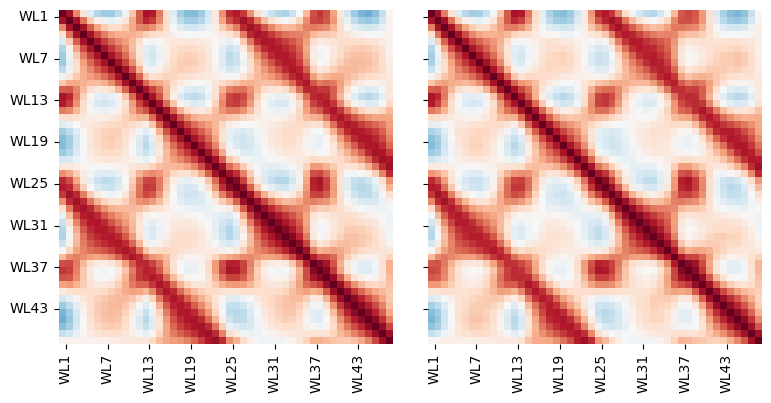

In [30]:
ax = bn.plot_scenarios_R(100)

In [31]:
energy_clusterer = ReduceForward(x=scenarios.values, cdn=5, dist='energy')
energy_clusterer.reduce_forward()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of  97 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    0.0s finishe

In [32]:
was_clusterer = ReduceForward(x=scenarios.values, cdn=5, dist='wasserstein')
was_clusterer.reduce_forward()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  99 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  58 out of  97 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:    0.0s finishe

In [33]:
def plot_clusters(clusterer, ax=None, **kwargs):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 3))
    cluster_scen_idx = [int(i) for i in clusterer.res[:,0]]
    weights = clusterer.res[:,1]
    for i in range(len(clusterer.x)):
        if not i in cluster_scen_idx:
            if i == 0:
                ax.step(range(1,49), clusterer.x[i,:], color='grey', alpha=0.1, lw=1, label='Original scenarios')
            else:
                ax.step(range(1,49), clusterer.x[i,:], color='grey', alpha=0.1, lw=1)
    
    weight_labels = [f'$w_{i}$ = {weights[i]:.2f}' for i in range(len(weights))]
    for i, j in enumerate(cluster_scen_idx):
        ax.step(range(1,49), clusterer.x[j,:], alpha=1, lw=1, label=weight_labels[i])
        
    # Now add the legend on the top of the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
    ax.set_xlim(1, 48)


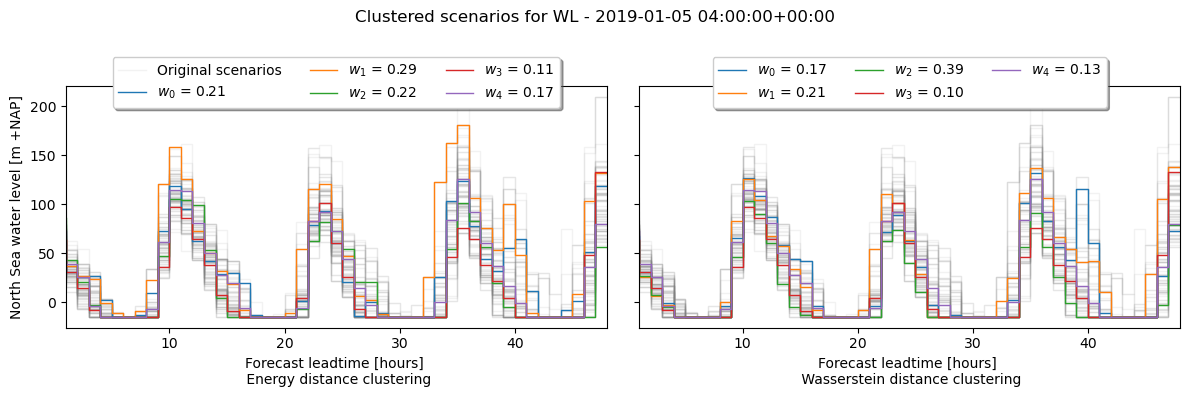

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plot_clusters(energy_clusterer, ax=ax[0])
ax[0].set_xlabel('Forecast leadtime [hours] \n Energy distance clustering')
# ax[0].set_ylabel('Discharge [$m^3s^{-1}$]')
# ax[0].set_ylabel('Price [€ MWh$^{-1}$]')
ax[0].set_ylabel('North Sea water level [m +NAP]')
plot_clusters(was_clusterer, ax=ax[1])
ax[1].set_xlabel('Forecast leadtime [hours] \n Wasserstein distance clustering')

fig.suptitle(f'Clustered scenarios for {name} - {distribution_df.index[idx]}')
fig.tight_layout()